## Notebook to check pre-thekla that the results make sense.

Load in, plot energy. thats all

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tables as tb
from matplotlib import colors
from tqdm import tqdm
import json



from typing          import Optional
from typing          import Union
from typing          import Callable
from typing          import Any

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_include-cluster-dropping/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_include-cluster-dropping/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range

from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

import glob
from tqdm import tqdm
# To get these back, figure out the compilation properly!
#import functions.functions_HE as func
#from invisible_cities.cities.beersheba    import hitc_to_df_


In [5]:
RUN_NUMBER = '15597'
TIMESTAMP  = '180725'

# solo file
##data = load_dst('/scratch/halmazan/NEXT/N100_LPR/15589/sophronia/110725/run_15589_ldc1_110725.h5', 'RECO', 'Events')
# or many files
folder_path = f'/scratch/halmazan/NEXT/N100_LPR/{RUN_NUMBER}/sophronia/{TIMESTAMP}/ldc1/'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
file_paths = [os.path.join(folder_path, f) for f in file_names]

data = load_dsts(file_paths[1000:], 'RECO', 'Events')

# or thekla post cuts
#data = load_dst('/scratch/halmazan/NEXT/N100_LPR/15590/thekla/120725/ldc1/run_15590_0001_ldc1_120725_thekla.h5', 'RECO', 'Events')



In [6]:
display(data)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1871010,1.752629e+09,4,42.911827,51.301156,1,-96.875,-16.425,0.0,0.0,-394.339688,8.153763,345.206458,-1.0,0.001640,-1,-1.0
1,1871010,1.752629e+09,4,42.911827,51.301156,1,196.575,183.725,0.0,0.0,-386.938938,10.595182,623.134686,-1.0,0.002979,-1,-1.0
2,1871010,1.752629e+09,4,42.911827,51.301156,1,196.575,199.275,0.0,0.0,-386.938938,8.456943,497.378340,-1.0,0.002380,-1,-1.0
3,1871010,1.752629e+09,4,42.911827,51.301156,1,181.025,183.725,0.0,0.0,-383.181031,7.311256,183.333905,-1.0,0.000878,-1,-1.0
4,1871010,1.752629e+09,4,42.911827,51.301156,1,181.025,214.825,0.0,0.0,-383.181031,7.666781,192.248897,-1.0,0.000920,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28626237,942614,1.752608e+09,52,-164.043697,172.473837,1,-220.275,-94.175,0.0,0.0,1553.563250,7.582610,4.365268,-1.0,0.000022,-1,-1.0
28626238,942614,1.752608e+09,52,-164.043697,172.473837,1,-96.875,369.325,0.0,0.0,1553.563250,7.795036,4.487561,-1.0,0.000024,-1,-1.0
28626239,942614,1.752608e+09,52,-164.043697,172.473837,1,-96.875,152.625,0.0,0.0,1557.483500,7.926603,4.051263,-1.0,0.000020,-1,-1.0
28626240,942614,1.752608e+09,52,-164.043697,172.473837,1,104.275,-417.725,0.0,0.0,1563.215500,9.335270,-2.677122,-1.0,-0.000016,-1,-1.0


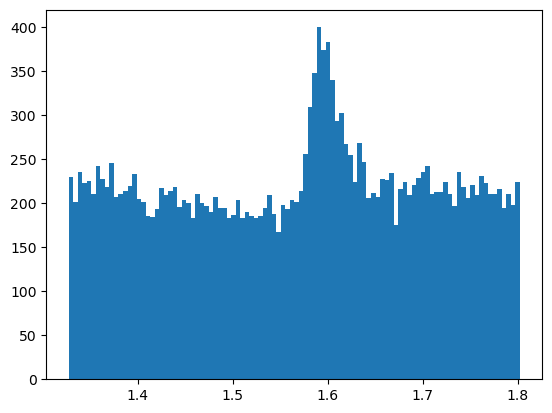

In [7]:
plt.hist(data.groupby('event').Ec.sum(), bins = 100)
plt.show()

In [ ]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z + 4, zz[i + 1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle(f"evt {evt}")
    plt.show(fig)


: 

In [15]:
stopper = 5
for i, (evt, df) in enumerate(data.groupby('event')):
    print('='*20)
    print('='*20)
    print(f'EVT: {evt}')
    print(np.average(np.diff(df.Z.values)))
    raw_plotter(df, evt)

    if i > stopper:
        break

: 

: 